In [1]:
import pandas as pd
from PIL import Image
import torch
from torch import cuda
import torchvision.transforms as transforms
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import os

In [2]:
#verifying that cuda is available
#torch.__version__
cuda.is_available()

True

In [19]:
#creating a custom pytorch dataset
rvlcdip_path = "./../data/raw/selected_sof/train"
#rvlcdip_path = "./../data/raw/selected"


In [20]:
class CustomDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.img_labels = self._get_img_labels()

    def _get_img_labels(self):
        img_labels = []
        for file in os.listdir(self.img_dir):
            if file.endswith(".txt"):
                with open(os.path.join(self.img_dir, file), 'r') as f:
                    label = f.read().strip()
                img_labels.append({"file": file.replace(".txt", ".tif"), "label": label})
        return pd.DataFrame(img_labels)

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    
data_transform = transforms.Compose([transforms.Resize((1000, 1000)),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5), (0.5))])

def target_transform(label, num_classes=16):
    one_hot = torch.zeros(num_classes)
    one_hot[int(label)] = 1
    return one_hot
    
dataset = CustomDataset(img_dir=rvlcdip_path, transform=data_transform, target_transform=target_transform)

In [21]:
dataset.__len__()

7174

In [35]:
#creating a custom pytorch dataloader
splits = random_split(dataset, [0.20,0.05,0.75])

train_loader = DataLoader(splits[0], batch_size=4, shuffle=True)
test_loader = DataLoader(splits[1], batch_size=1, shuffle=False)

In [36]:
enumerate(train_loader)

In [37]:
len(train_loader)

359

In [38]:
len(test_loader)

359

In [18]:
splits[0][5][1]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

In [39]:
#Defining a simple cnn model
import torch.nn as nn
import torch.nn.functional as F

In [24]:
class MyFirstCNN(nn.Module):
    
    def __init__(self):
        super(MyFirstCNN, self).__init__()
        self.categories = 16 #Nombre de categories ImageNet

        #1000,1000,1
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 5),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride = 2)
        )
        #498, 498, 16
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride = 2)
        )
        #247, 247, 32
        
        self.classify = nn.Sequential(
            nn.Linear(in_features = 247*247*32, out_features = 128),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(in_features = 128, out_features = 32),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(in_features = 32, out_features = self.categories)
                                      
        )
        
        pass
        
        
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = x.view(x.size(0), -1)
        x = self.classify(x)
        return x

In [23]:
class MySecondCNN(nn.Module):
    
    def __init__(self):
        super(MySecondCNN, self).__init__()
        self.categories = 16 #Nombre de categories ImageNet

        #1000,1000,1
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 5, padding = 6),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 5, padding = 6),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride = 2)
        )
        #504, 504, 16
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5, padding = 6),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 5, padding = 6),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride = 2)
        )
        #256, 256, 32
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 5, padding = 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 5, padding = 2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride = 2)
        )
        #128, 128, 64
        self.block4 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 5, padding = 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 5, padding = 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 5, padding = 2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride = 2)
        )
        #64, 64, 128
        self.block5 = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 5, padding = 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 5, padding = 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 5, padding = 2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride = 2)
        )
        #32, 32, 256
        self.block6 = nn.Sequential(
            nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 5, padding = 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 5, padding = 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 5, padding = 2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride = 2)
        )
        #16, 16, 512
        """self.block5 = nn.Sequential(
            nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5, padding = 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 5, padding = 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 5, padding = 2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride = 2)
        )
        #8, 8, 512"""
        
        self.classify = nn.Sequential(
            nn.Linear(in_features = 16*16*512, out_features = 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(in_features = 2048, out_features = 128),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(in_features = 128, out_features = self.categories)
                                      
        )
        
        pass
        
        
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = x.view(x.size(0), -1)
        x = self.classify(x)
        return x

In [79]:
class MyThirdCNN(nn.Module):
    
    def __init__(self):
        super(MyThirdCNN, self).__init__()
        self.categories = 16 #Nombre de categories ImageNet

        #1000,1000,1
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 5, padding = 6),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 5, padding = 6),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride = 2)
        )
        #504, 504, 16
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5, padding = 6),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 5, padding = 6),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride = 2)
        )
        #256, 256, 32
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 5, padding = 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 5, padding = 2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride = 2)
        )
        #128, 128, 64
        """self.block4 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 5, padding = 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 5, padding = 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 5, padding = 2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride = 2)
        )
        #64, 64, 128
        self.block5 = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 5, padding = 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 5, padding = 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 5, padding = 2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride = 2)
        )
        #32, 32, 256
        self.block6 = nn.Sequential(
            nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 5, padding = 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 5, padding = 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 5, padding = 2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride = 2)
        )
        #16, 16, 512
        """
        
        self.classify = nn.Sequential(
            nn.Linear(in_features = 131*131*64, out_features = 256),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(in_features = 256, out_features = 64),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(in_features = 64, out_features = self.categories)
                                      
        )

        """self.classify2 = nn.Sequential(
            nn.Linear(in_features = 64*128*128, out_features = 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
                                      
        )"""
        
        pass
        
        
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        #x = self.block4(x)
        #x = self.block5(x)
        #x = self.block6(x)
        #print(x.size())
        x = x.view(x.size(0), -1)
        #x = self.classify2(x)
        #print(x.size())
        x = self.classify(x)
        return x

In [11]:
#Defining a simple cnn model
import torch.nn as nn
import torch.nn.functional as F

#The formula for calculating the output size of a convolutional layer is:
#[(W−K+2P)/S]+1.

#    W is the input volume - 1000
#    K is the Kernel size - 5
#    P is the padding - 0
#    S is the stride - 1


class FirstCNN(nn.Module):
    def __init__(self):
        super(FirstCNN, self).__init__()
        #1,1000,1000
        self.conv1 = nn.Conv2d(1, 16, 5)
        #16,996,996
        self.pool1 = nn.MaxPool2d(2, 2)
        #16,498,498
        self.conv2 = nn.Conv2d(16, 32, 5)
        #32,494,494
        self.pool2 = nn.MaxPool2d(2, 2)
        #32,247,247
        self.fc1 = nn.Linear(32 * 247 * 247, 120)
        #120
        self.fc2 = nn.Linear(120, 84)
        #84
        self.fc3 = nn.Linear(84, 16)
        #16

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 247 * 247)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
#initializing the model
model = FirstCNN()

#visualizing the model
print(model)

FirstCNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1952288, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=16, bias=True)
)


In [80]:
model_3cnn = MyThirdCNN()

print(model_3cnn)

MyThirdCNN(
  (block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(6, 6))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(6, 6))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(6, 6))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(6, 6))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classify): Sequential(
    (0): 

In [81]:
#compiling the model
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_3cnn.parameters(), lr=0.001)

In [82]:
len(train_loader)

359

In [83]:
len(test_loader)

359

In [84]:
#training the model
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model_3cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 5 == 4:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 5))
            running_loss = 0.0

print('Entrainement terminé')

[1,     5] loss: 2.790
[1,    10] loss: 2.768
[1,    15] loss: 2.761
[1,    20] loss: 2.776
[1,    25] loss: 2.790
[1,    30] loss: 2.779
[1,    35] loss: 2.756
[1,    40] loss: 2.791
[1,    45] loss: 2.775
[1,    50] loss: 2.757
[1,    55] loss: 2.760
[1,    60] loss: 2.775
[1,    65] loss: 2.754
[1,    70] loss: 2.788
[1,    75] loss: 2.763
[1,    80] loss: 2.762
[1,    85] loss: 2.780
[1,    90] loss: 2.729
[1,    95] loss: 2.808
[1,   100] loss: 2.773
[1,   105] loss: 2.789
[1,   110] loss: 2.784
[1,   115] loss: 2.744
[1,   120] loss: 2.798
[1,   125] loss: 2.760
[1,   130] loss: 2.754
[1,   135] loss: 2.805
[1,   140] loss: 2.758
[1,   145] loss: 2.745
[1,   150] loss: 2.779
[1,   155] loss: 2.763
[1,   160] loss: 2.760
[1,   165] loss: 2.775
[1,   170] loss: 2.735
[1,   175] loss: 2.785
[1,   180] loss: 2.786
[1,   185] loss: 2.759
[1,   190] loss: 2.744
[1,   195] loss: 2.796
[1,   200] loss: 2.780
[1,   205] loss: 2.768
[1,   210] loss: 2.772
[1,   215] loss: 2.778
[1,   220] 

In [ ]:
model_3cnn

In [86]:
torch.save(model_3cnn.state_dict(), './../models/third_version_cnn.pt')
torch.save(model_3cnn.state_dict(), './../models/third_version_cnn.pth')

In [87]:
#predicting with the model
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model_3cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Precision sur le jeu de test: %d %%' % (
    100 * correct / total))

Precision sur le jeu de test: 0 %


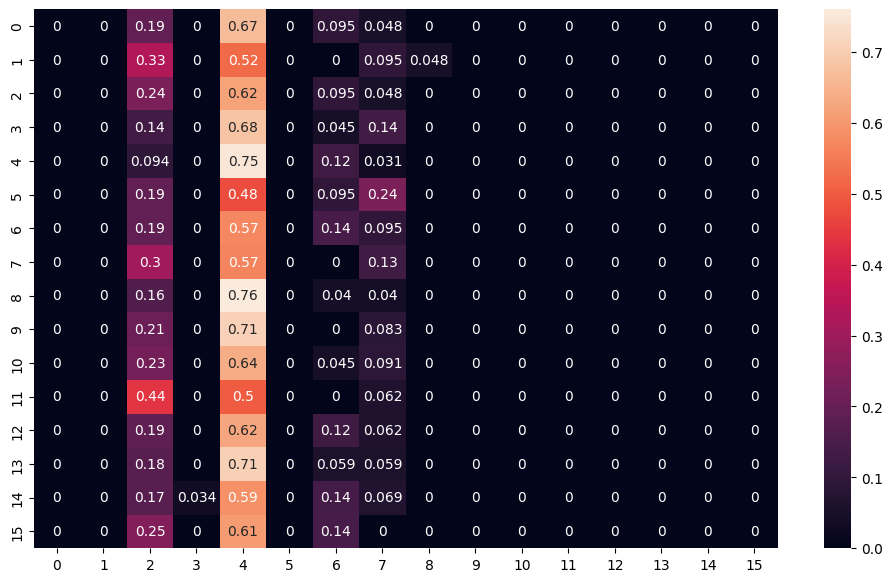

In [88]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        output = model_3cnn(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = (torch.max(torch.exp(labels), 1)[1]).data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
#classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None]) 
#index = [i for i in classes],columns = [i for i in classes]
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [25]:
model2 = MySecondCNN()
#visualizing the model
print(model2)

MySecondCNN(
  (block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(6, 6))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(6, 6))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(6, 6))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(6, 6))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block4): Sequential(
    (0): C

In [28]:
model_3 = FirstCNN()
#visualizing the model
print(model_3)

FirstCNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1952288, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=16, bias=True)
)


In [29]:
#compiling the model
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_3.parameters(), lr=0.0001)

In [30]:
#training the model
for epoch in range(15):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model_3(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 5 == 4:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 5))
            running_loss = 0.0

print('Entrainement terminé')

[1,     5] loss: 2.745
[1,    10] loss: 2.796
[1,    15] loss: 2.778
[1,    20] loss: 2.784
[1,    25] loss: 2.823
[1,    30] loss: 2.778
[1,    35] loss: 2.776
[1,    40] loss: 2.764
[1,    45] loss: 2.786
[1,    50] loss: 2.751
[1,    55] loss: 2.783
[1,    60] loss: 2.772
[1,    65] loss: 2.785
[1,    70] loss: 2.748
[1,    75] loss: 2.770
[1,    80] loss: 2.765
[1,    85] loss: 2.755
[1,    90] loss: 2.755
[1,    95] loss: 2.753
[1,   100] loss: 2.737
[1,   105] loss: 2.745
[1,   110] loss: 2.725
[1,   115] loss: 2.818
[1,   120] loss: 2.793
[1,   125] loss: 2.782
[1,   130] loss: 2.828
[1,   135] loss: 2.732
[1,   140] loss: 2.782
[1,   145] loss: 2.774
[1,   150] loss: 2.790
[1,   155] loss: 2.733
[1,   160] loss: 2.771
[1,   165] loss: 2.790
[1,   170] loss: 2.786
[1,   175] loss: 2.757
[1,   180] loss: 2.768
[1,   185] loss: 2.787
[1,   190] loss: 2.770
[1,   195] loss: 2.760
[1,   200] loss: 2.750
[1,   205] loss: 2.802
[1,   210] loss: 2.811
[1,   215] loss: 2.769
[1,   220] 

In [31]:
#predicting with the model
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model_3(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Precision sur le jeu de test: %d %%' % (
    100 * correct / total))

Precision sur le jeu de test: 33 %


In [32]:
import numpy as np
import keras
from keras import ops

In [33]:
model_3.save('./../models/first_easy_cnn.keras')

AttributeError: 'FirstCNN' object has no attribute 'save'

In [37]:
torch.save(model_3.state_dict(), './../models/first_easy_cnn.pth')

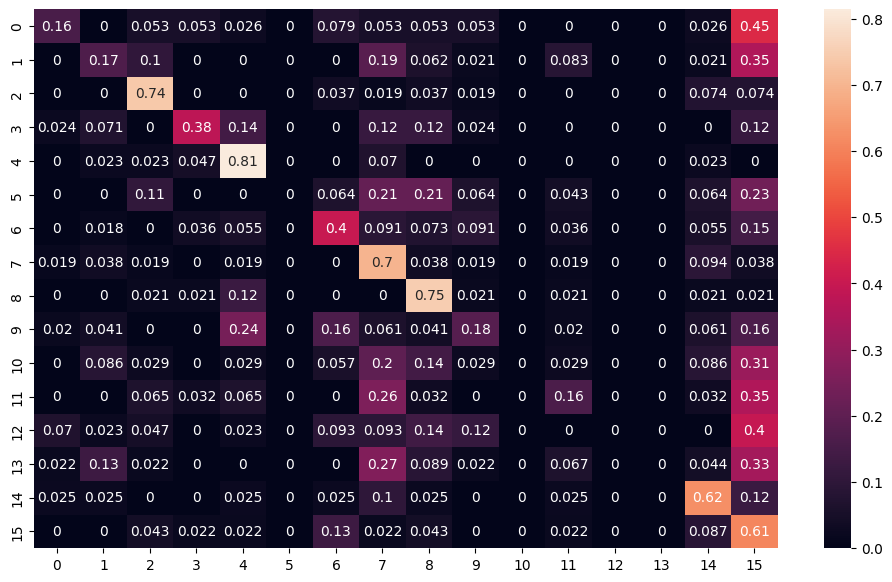

In [47]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        output = model_3(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = (torch.max(torch.exp(labels), 1)[1]).data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
#classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None]) 
#index = [i for i in classes],columns = [i for i in classes]
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [45]:
y_true 

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       dtype=float32),
 array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       dtype=float32),
 array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 array([0., 0., 1., 0., 0., 0., 0., 0., 

In [13]:
#initializing the model
model = FirstCNN()

#visualizing the model
print(model)

FirstCNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1952288, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=16, bias=True)
)


In [14]:
#compiling the model
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001)

In [20]:
#training the model
for epoch in range(5):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 5 == 4:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 5))
            running_loss = 0.0

print('Entrainement terminé')

[1,     5] loss: 2.713
[1,    10] loss: 2.735
[1,    15] loss: 2.690
[1,    20] loss: 2.683
[1,    25] loss: 2.812
[1,    30] loss: 2.404
[1,    35] loss: 2.545
[1,    40] loss: 2.567
[1,    45] loss: 2.438
[1,    50] loss: 2.660
[1,    55] loss: 2.512
[1,    60] loss: 2.633
[1,    65] loss: 2.518
[1,    70] loss: 2.629
[1,    75] loss: 2.630
[1,    80] loss: 2.569
[1,    85] loss: 2.651
[1,    90] loss: 2.693
[1,    95] loss: 2.603
[1,   100] loss: 2.680
[1,   105] loss: 2.591
[1,   110] loss: 2.755
[1,   115] loss: 2.739
[1,   120] loss: 2.482
[1,   125] loss: 2.667
[1,   130] loss: 2.737
[1,   135] loss: 2.706
[1,   140] loss: 2.699
[1,   145] loss: 2.611
[1,   150] loss: 2.696
[1,   155] loss: 2.712
[1,   160] loss: 2.464
[1,   165] loss: 2.616
[1,   170] loss: 2.709
[1,   175] loss: 2.672
[1,   180] loss: 2.585
[1,   185] loss: 2.207
[1,   190] loss: 2.698
[1,   195] loss: 2.614
[1,   200] loss: 2.698
[1,   205] loss: 2.703
[1,   210] loss: 2.691
[1,   215] loss: 2.544
[1,   220] 

In [22]:
#predicting with the model
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Precision sur le jeu de test: %d %%' % (
    100 * correct / total))

Precision sur le jeu de test: 3 %


In [46]:
#initializing the model
model = MySecondCNN()

#visualizing the model
print(model)

MySecondCNN(
  (block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(6, 6))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(6, 6))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(6, 6))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(6, 6))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block4): Sequential(
    (0): C

In [47]:
#compiling the model
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [48]:
#training the model
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 5 == 4:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 5))
            running_loss = 0.0

print('Entrainement terminé')

[1,     5] loss: 2.769
[1,    10] loss: 2.795
[1,    15] loss: 2.762
[1,    20] loss: 2.780
[1,    25] loss: 2.784
[1,    30] loss: 2.758
[1,    35] loss: 2.778
[1,    40] loss: 2.769
[1,    45] loss: 2.767
[1,    50] loss: 2.779
[1,    55] loss: 2.767
[1,    60] loss: 2.758
[1,    65] loss: 2.779
[1,    70] loss: 2.768
[1,    75] loss: 2.773
[1,    80] loss: 2.781
[1,    85] loss: 2.771
[1,    90] loss: 2.775
[1,    95] loss: 2.771
[1,   100] loss: 2.761
[1,   105] loss: 2.778
[1,   110] loss: 2.810
[1,   115] loss: 2.760
[1,   120] loss: 2.780
[1,   125] loss: 2.761
[1,   130] loss: 2.776
[1,   135] loss: 2.774
[1,   140] loss: 2.747
[1,   145] loss: 2.762
[1,   150] loss: 2.793
[1,   155] loss: 2.786
[1,   160] loss: 2.785
[1,   165] loss: 2.778
[1,   170] loss: 2.776
[1,   175] loss: 2.777
[1,   180] loss: 2.778
[1,   185] loss: 2.766
[1,   190] loss: 2.785
[1,   195] loss: 2.755
[2,     5] loss: 2.759
[2,    10] loss: 2.774
[2,    15] loss: 2.772
[2,    20] loss: 2.776
[2,    25] 

In [49]:
#predicting with the model
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Precision sur le jeu de test: %d %%' % (
    100 * correct / total))

Precision sur le jeu de test: 0 %


In [14]:
#predicting with the model
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Precision sur le jeu de test: %d %%' % (
    100 * correct / total))

Precision sur le jeu de test: 7 %


In [ ]:
trainer_generic(model = model.classify,size = 199, features = train_feat, labels = train_label,
            epochs = 10, optimizer=optimizer_mynet,train=True,shuffle=True)


In [ ]:


#The formula for calculating the output size of a convolutional layer is:
#[(W−K+2P)/S]+1.

#    W is the input volume - 1000
#    K is the Kernel size - 5
#    P is the padding - 0
#    S is the stride - 1


class FirstCNN(nn.Module):
    def __init__(self):
        super(FirstCNN, self).__init__()
        #1,1000,1000
        self.conv1 = nn.Conv2d(1, 16, 5)
        #16,996,996
        self.pool1 = nn.MaxPool2d(2, 2)
        #16,498,498
        self.conv2 = nn.Conv2d(16, 32, 5)
        #32,494,494
        self.pool2 = nn.MaxPool2d(2, 2)
        #32,247,247
        self.fc1 = nn.Linear(32 * 247 * 247, 120)
        #120
        self.fc2 = nn.Linear(120, 84)
        #84
        self.fc3 = nn.Linear(84, 16)
        #16

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 247 * 247)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
#initializing the model
model = FirstCNN()

#visualizing the model
print(model)

In [13]:
a = 1000
p = 0
s = 1
m=0
dict_k = {}

for k in range(8):
    for p in range(8):
        for s in range(1,8):
            a = 1000
            i=0
            m+=1
            print(m)
            while ((a-k +2*p)/s+1)%2==0:
                a = ((a-k +2*p)/s+1)//2
                i+=1
            dict_k[(k,p,s)] = i


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [17]:
dict_k[(1,4,1)]


5

In [16]:
max(dict_k, key=dict_k.get)

(1, 4, 1)

In [26]:
test = list(dict_k.values())

In [27]:
print(test)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 3, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 5, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 3, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 5, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 3, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 5, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 

In [28]:
[k for k, v in dict_k.items() if v == 5]

[(1, 4, 1), (3, 5, 1), (5, 6, 1), (7, 7, 1)]

In [15]:
dict_k

{(1, 0): 3,
 (2, 0): 0,
 (2, 1): 0,
 (3, 0): 1,
 (3, 1): 1,
 (3, 2): 1,
 (4, 0): 0,
 (4, 1): 0,
 (4, 2): 0,
 (4, 3): 0,
 (5, 0): 2,
 (5, 1): 2,
 (5, 2): 2,
 (5, 3): 2,
 (5, 4): 2,
 (6, 0): 0,
 (6, 1): 0,
 (6, 2): 0,
 (6, 3): 0,
 (6, 4): 0,
 (6, 5): 0,
 (7, 0): 1,
 (7, 1): 1,
 (7, 2): 1,
 (7, 3): 1,
 (7, 4): 1,
 (7, 5): 1,
 (7, 6): 1}

In [12]:
13 / 2

6.5